In [7]:
from google.colab import files
files.upload()

Saving monthly-car-sales.csv to monthly-car-sales.csv


{'monthly-car-sales.csv': b'"Month","Sales"\r\n"1960-01",6550\r\n"1960-02",8728\r\n"1960-03",12026\r\n"1960-04",14395\r\n"1960-05",14587\r\n"1960-06",13791\r\n"1960-07",9498\r\n"1960-08",8251\r\n"1960-09",7049\r\n"1960-10",9545\r\n"1960-11",9364\r\n"1960-12",8456\r\n"1961-01",7237\r\n"1961-02",9374\r\n"1961-03",11837\r\n"1961-04",13784\r\n"1961-05",15926\r\n"1961-06",13821\r\n"1961-07",11143\r\n"1961-08",7975\r\n"1961-09",7610\r\n"1961-10",10015\r\n"1961-11",12759\r\n"1961-12",8816\r\n"1962-01",10677\r\n"1962-02",10947\r\n"1962-03",15200\r\n"1962-04",17010\r\n"1962-05",20900\r\n"1962-06",16205\r\n"1962-07",12143\r\n"1962-08",8997\r\n"1962-09",5568\r\n"1962-10",11474\r\n"1962-11",12256\r\n"1962-12",10583\r\n"1963-01",10862\r\n"1963-02",10965\r\n"1963-03",14405\r\n"1963-04",20379\r\n"1963-05",20128\r\n"1963-06",17816\r\n"1963-07",12268\r\n"1963-08",8642\r\n"1963-09",7962\r\n"1963-10",13932\r\n"1963-11",15936\r\n"1963-12",12628\r\n"1964-01",12267\r\n"1964-02",12470\r\n"1964-03",18944\r\n"

In [9]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
  return data[:-n_test], data[-n_test:]

In [10]:
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
  df = DataFrame(data)
  cols = list()
# input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
# put it all together
  agg = concat(cols, axis=1)
# drop rows with NaN values
  agg.dropna(inplace=True)
  return agg.values

In [11]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
  return sqrt(mean_squared_error(actual, predicted))

In [12]:
# difference dataset
def difference(data, interval):
  return [data[i] - data[i - interval] for i in range(interval, len(data))]

In [13]:
# fit a model
def model_fit(train, config):
  
  n_input, n_nodes, n_epochs, n_batch, n_diff = config
# prepare data
  if n_diff > 0:
    train = difference(train, n_diff)
  data = series_to_supervised(train, n_input)
  train_x, train_y = data[:, :-1], data[:, -1]
  train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
# define model
  model = Sequential()
  model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
  model.add(Dense(n_nodes, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
# fit
  model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
  return model

In [14]:
# forecast with a pre-fit model
def model_predict(model, history, config):
# unpack config
  n_input, _, _, _, n_diff = config
# prepare data
  correction = 0.0
  if n_diff > 0:
    correction = history[-n_diff]
    history = difference(history, n_diff)
  x_input = array(history[-n_input:]).reshape((1, n_input, 1))
# forecast
  yhat = model.predict(x_input, verbose=0)
  return correction + yhat[0]

In [15]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
  predictions = list()
# split dataset
  train, test = train_test_split(data, n_test)
# fit model
  model = model_fit(train, cfg)
# seed history with training dataset
  history = [x for x in train]
# step over each time-step in the test set
  for i in range(len(test)):
# fit model and make forecast for history
    yhat = model_predict(model, history, cfg)
# store forecast in list of predictions
    predictions.append(yhat)
# add actual observation to history for the next loop
    history.append(test[i])
# estimate prediction error
  error = measure_rmse(test, predictions)
  print(' > %.3f' % error)
  return error

In [16]:
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
# fit and evaluate the model n times
  scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
  return scores

In [17]:
# summarize model performance
def summarize_scores(name, scores):
# print a summary
  scores_m, score_std = mean(scores), std(scores)
  print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
# box and whisker plot
  pyplot.boxplot(scores)
  pyplot.show()

 > 2113.651
 > 1981.709
 > 1958.925
 > 2135.752
 > 2006.279
 > 2043.018
 > 2133.059
 > 2143.179
 > 2171.705
 > 2150.106
 > 2007.074
 > 2217.928
 > 2020.994
 > 2006.737
 > 2040.212
 > 2194.990
 > 2169.426
 > 1971.139
 > 2127.486
 > 2178.221
 > 2184.963
 > 1988.954
 > 2046.132
 > 2089.263
 > 1881.724
 > 2124.331
 > 2066.141
 > 1881.479
 > 2019.622
 > 2201.826
lstm: 2075.201 RMSE (+/- 92.098)


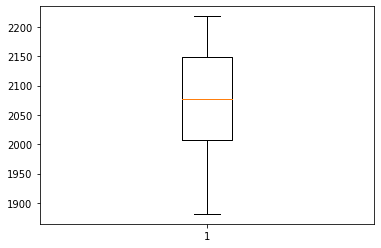

In [20]:
import warnings
warnings.filterwarnings('ignore')
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [36, 50, 100, 100, 12]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('lstm', scores)